In [1]:
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential
import keras.layers as layers
from tensorflow.keras.layers import Dense
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Dropout
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

In [2]:
from keras.preprocessing.image import ImageDataGenerator

In [3]:
train_path = '/kaggle/input/wheather-classfication/Weather Resized/Weather Resized'
test_path  = '/kaggle/input/wheather-classfication/Weather Resized/Weather Resized'

In [4]:
df = pd.read_csv('/kaggle/input/wheather-classfication/Label_wheather_class.csv')

In [5]:
X = df['Img_dir']
y = df['Label_img']

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 28, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.5, random_state = 28, stratify=y_val)

In [7]:
y_train = y_train.astype(str)
y_val = y_val.astype(str)
y_test = y_test.astype(str)

In [8]:
train_df= pd.DataFrame(columns=['Images','Label'])
# train_df= pd.DataFrame(data = [X_train,y_train], columns=['Images','Label'])
train_df['Images'] = X_train
train_df['Label'] = y_train
valid_df= pd.DataFrame(columns=['Images','Label'])
valid_df['Images'] = X_val
valid_df['Label'] = y_val
test_df= pd.DataFrame(columns=['Images','Label'])
test_df['Images'] = X_test
test_df['Label'] = y_test

In [9]:
train_df['Label'].isna().sum(),y_train.isna().sum()

(0, 0)

In [10]:
train_df.isna().sum()

Images    0
Label     0
dtype: int64

In [11]:
datagen = ImageDataGenerator(
        rotation_range=30, # rotation
        zoom_range=0.2, # zoom
        horizontal_flip=True, # horizontal flip
        brightness_range=[0.2,1.2]) # brightness

In [12]:
datagen2 = ImageDataGenerator()

In [13]:
y_test_arr = np.array(y_test)
y_test_arr = y_test_arr.astype(int)

In [14]:
train_generator_df = datagen.flow_from_dataframe(dataframe=train_df, 
                                              directory=train_path,
                                              x_col="Images", 
                                              y_col="Label", 
                                              class_mode="categorical", 
                                              target_size=(64, 64), 
                                              batch_size=16,
                                              rescale=1.0/255,
                                              seed=28)

Found 900 validated image filenames belonging to 4 classes.


In [15]:
test_generator_df = datagen.flow_from_dataframe(dataframe=test_df, 
                                              directory=test_path,
                                              x_col="Images", 
                                              y_col="Label", 
                                              class_mode="categorical", 
                                              target_size=(64, 64), 
                                              batch_size=16,
                                              rescale=1.0/255,
                                              seed=28,
                                              shuffle = False)

Found 113 validated image filenames belonging to 4 classes.


In [16]:
valid_generator_df = datagen.flow_from_dataframe(dataframe=valid_df, 
                                              directory=train_path,
                                              x_col="Images", 
                                              y_col="Label", 
                                              class_mode="categorical", 
                                              target_size=(64, 64), 
                                              batch_size=16,
                                              rescale=1.0/255,
                                              seed=28)

Found 112 validated image filenames belonging to 4 classes.


In [17]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

2023-01-04 16:27:35.334225: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-04 16:27:35.632224: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-04 16:27:35.633137: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-04 16:27:35.634571: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [37]:
base_model = tf.keras.applications.VGG19(
        input_shape=(64, 64, 3),
        include_top=False,
        weights="imagenet",
)
base_model.trainable = True
model2 = tf.keras.Sequential([
    tf.keras.Input(shape=(64, 64, 3)),
    data_augmentation,
    layers.Rescaling(scale=1.0/255), # rescale the pixel values to the [0, 1] range
    base_model,
    # add a new FC classifier on top of the base model
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(4, activation='softmax'),
])
learning_rate = 1e-4
model2.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=['acc']
             )

epochs = 20
history_vgg_sparse = model2.fit(train_generator_df, epochs=epochs,
                   validation_data=valid_generator_df)

Epoch 1/20
57/57 [==============================] - 4s 55ms/step - loss: 1.0149 - acc: 0.5611 - val_loss: 0.6075 - val_acc: 0.7054
Epoch 2/20
57/57 [==============================] - 3s 47ms/step - loss: 0.5229 - acc: 0.7889 - val_loss: 0.6015 - val_acc: 0.7857
Epoch 3/20
57/57 [==============================] - 3s 52ms/step - loss: 0.3622 - acc: 0.8722 - val_loss: 0.4119 - val_acc: 0.8571
Epoch 4/20
57/57 [==============================] - 3s 47ms/step - loss: 0.3025 - acc: 0.9033 - val_loss: 0.2650 - val_acc: 0.9018
Epoch 5/20
57/57 [==============================] - 3s 59ms/step - loss: 0.2495 - acc: 0.9167 - val_loss: 0.1496 - val_acc: 0.9464
Epoch 6/20
57/57 [==============================] - 3s 46ms/step - loss: 0.3562 - acc: 0.8667 - val_loss: 0.4169 - val_acc: 0.7857
Epoch 7/20
57/57 [==============================] - 3s 47ms/step - loss: 0.3183 - acc: 0.8800 - val_loss: 0.2056 - val_acc: 0.9018
Epoch 8/20
57/57 [==============================] - 3s 48ms/step - loss: 0.3270 - a

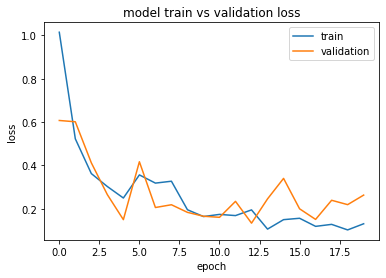

In [38]:
plt.plot(history_vgg_sparse.history['loss'])
plt.plot(history_vgg_sparse.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

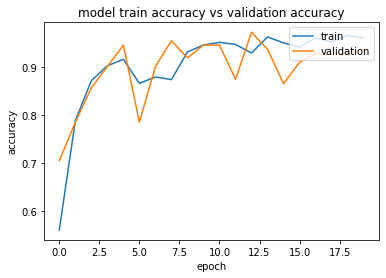

In [39]:
plt.plot(history_vgg_sparse.history['acc'])
plt.plot(history_vgg_sparse.history['val_acc'])
plt.title('model train accuracy vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


0.9292035398230089


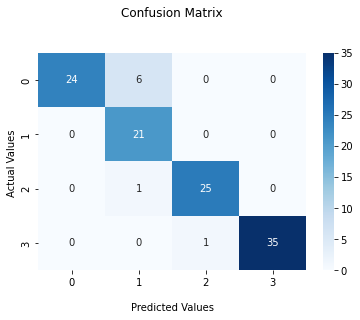

In [40]:
pred = model2.predict_generator(generator=test_generator_df).argmax(-1)
print(accuracy_score(pred,y_test_arr))
ax = sns.heatmap(confusion_matrix(y_test_arr, pred), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
plt.show()

In [41]:
print(classification_report(y_test_arr, pred))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89        30
           1       0.75      1.00      0.86        21
           2       0.96      0.96      0.96        26
           3       1.00      0.97      0.99        36

    accuracy                           0.93       113
   macro avg       0.93      0.93      0.92       113
weighted avg       0.94      0.93      0.93       113



VGG19

In [21]:
base_model = tf.keras.applications.VGG19(
        input_shape=(64, 64, 3),
        include_top=False,
        weights="imagenet",
)

80150528/80134624 [==============================] - 4s 0us/step


In [22]:
base_model.trainable = True

In [23]:
model2 = tf.keras.Sequential([
    tf.keras.Input(shape=(64, 64, 3)),
    data_augmentation,
    layers.Rescaling(scale=1.0/255), # rescale the pixel values to the [0, 1] range
    base_model,
    # add a new FC classifier on top of the base model
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(4, activation='softmax'),
])

In [24]:
learning_rate = 1e-4
model2.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
              metrics=['acc']
             )

epochs = 15
history = model2.fit(train_generator_df, epochs=epochs,
                   validation_data=valid_generator_df)

2023-01-03 10:59:16.848791: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2023-01-03 10:59:19.786749: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


57/57 [==============================] - 13s 84ms/step - loss: 0.4863 - acc: 0.4322 - val_loss: 0.3600 - val_acc: 0.5982
Epoch 2/15
57/57 [==============================] - 3s 49ms/step - loss: 0.2444 - acc: 0.7967 - val_loss: 0.2078 - val_acc: 0.7857
Epoch 3/15
57/57 [==============================] - 3s 49ms/step - loss: 0.2274 - acc: 0.8311 - val_loss: 0.1107 - val_acc: 0.9196
Epoch 4/15
57/57 [==============================] - 3s 48ms/step - loss: 0.1824 - acc: 0.8778 - val_loss: 0.2424 - val_acc: 0.8125
Epoch 5/15
57/57 [==============================] - 4s 75ms/step - loss: 0.1660 - acc: 0.8911 - val_loss: 0.0923 - val_acc: 0.9375
Epoch 6/15
57/57 [==============================] - 3s 58ms/step - loss: 0.1510 - acc: 0.8967 - val_loss: 0.0752 - val_acc: 0.9464
Epoch 7/15
57/57 [==============================] - 4s 78ms/step - loss: 0.1443 - acc: 0.8944 - val_loss: 0.0920 - val_acc: 0.9107
Epoch 8/15
57/57 [==============================] - 4s 66ms/step - loss: 0.1194 - acc: 0.9322

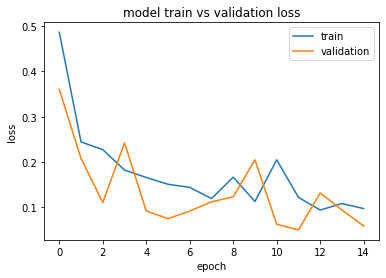

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

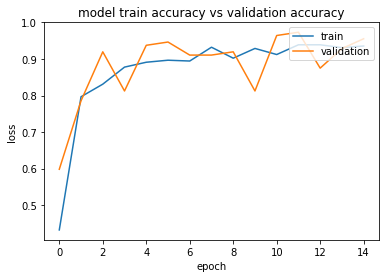

In [27]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model train accuracy vs validation accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [42]:
pred = model2.predict_generator(generator=test_generator_df).argmax(-1)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [63]:
print(accuracy_score(pred,y_test_arr))

0.9203539823008849


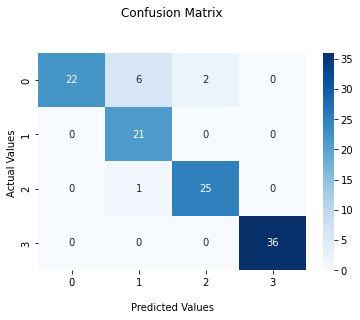

In [67]:
ax = sns.heatmap(confusion_matrix(y_test_arr, pred), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
plt.show()

In [68]:
print(classification_report(y_test_arr, pred))

              precision    recall  f1-score   support

           0       1.00      0.73      0.85        30
           1       0.75      1.00      0.86        21
           2       0.93      0.96      0.94        26
           3       1.00      1.00      1.00        36

    accuracy                           0.92       113
   macro avg       0.92      0.92      0.91       113
weighted avg       0.94      0.92      0.92       113



VGG19 pake Adam

In [76]:
base_model = tf.keras.applications.VGG19(
        input_shape=(64, 64, 3),
        include_top=False,
        weights="imagenet",
)
base_model.trainable = True
model_vgg19_2 = tf.keras.Sequential([
    tf.keras.Input(shape=(64, 64, 3)),
    data_augmentation,
    layers.Rescaling(scale=1.0/255), # rescale the pixel values to the [0, 1] range
    base_model,
    # add a new FC classifier on top of the base model
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(4, activation='softmax'),
])
learning_rate = 1e-4
model_vgg19_2.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=['acc']
             )

epochs = 20
history_model_vgg19_2 = model_vgg19_2.fit(train_generator_df, epochs=epochs,
                   validation_data=valid_generator_df)

Epoch 1/20
57/57 [==============================] - 4s 52ms/step - loss: 0.4183 - acc: 0.5511 - val_loss: 0.3836 - val_acc: 0.5804
Epoch 2/20
57/57 [==============================] - 3s 46ms/step - loss: 0.2669 - acc: 0.7611 - val_loss: 0.3627 - val_acc: 0.5804
Epoch 3/20
57/57 [==============================] - 3s 46ms/step - loss: 0.2241 - acc: 0.8322 - val_loss: 0.1433 - val_acc: 0.9018
Epoch 4/20
57/57 [==============================] - 3s 51ms/step - loss: 0.1435 - acc: 0.9044 - val_loss: 0.1405 - val_acc: 0.8839
Epoch 5/20
57/57 [==============================] - 3s 47ms/step - loss: 0.1321 - acc: 0.8989 - val_loss: 0.1174 - val_acc: 0.9464
Epoch 6/20
57/57 [==============================] - 3s 47ms/step - loss: 0.1125 - acc: 0.9256 - val_loss: 0.1255 - val_acc: 0.9375
Epoch 7/20
57/57 [==============================] - 3s 48ms/step - loss: 0.1162 - acc: 0.9200 - val_loss: 0.1007 - val_acc: 0.9375
Epoch 8/20
57/57 [==============================] - 3s 46ms/step - loss: 0.1022 - a

In [78]:
pred_vgg_2 = model_vgg19_2.predict_generator(generator=test_generator_df).argmax(-1)
print(accuracy_score(y_test_arr, pred_vgg_2))
print(classification_report(y_test_arr, pred_vgg_2))

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


0.9203539823008849
              precision    recall  f1-score   support

           0       0.96      0.80      0.87        30
           1       0.75      1.00      0.86        21
           2       0.96      0.92      0.94        26
           3       1.00      0.97      0.99        36

    accuracy                           0.92       113
   macro avg       0.92      0.92      0.91       113
weighted avg       0.93      0.92      0.92       113



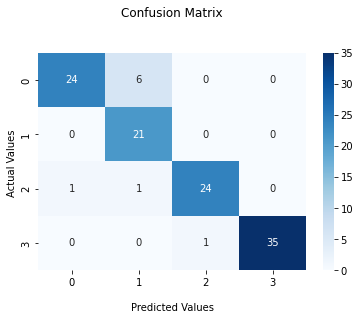

In [79]:
ax = sns.heatmap(confusion_matrix(y_test_arr, pred_vgg_2), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
plt.show()

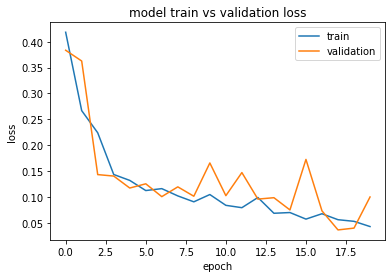

In [80]:
plt.plot(history_model_vgg19_2.history['loss'])
plt.plot(history_model_vgg19_2.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

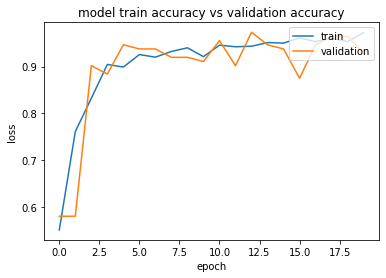

In [81]:
plt.plot(history_model_vgg19_2.history['acc'])
plt.plot(history_model_vgg19_2.history['val_acc'])
plt.title('model train accuracy vs validation accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Resnet

In [86]:
import keras
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, add, GlobalAveragePooling2D
from keras.models import Model

def resnet_block(inputs, filters, kernel_size, strides, use_shortcut=False):
  x = Conv2D(filters, kernel_size, strides=strides, padding='same')(inputs)
  x = Activation('relu')(x)
  x = Conv2D(filters, kernel_size, strides=1, padding='same')(x)
  x = Activation('relu')(x)
  if use_shortcut:
    shortcut = Conv2D(filters, 1, strides=strides)(inputs)
    x = add([x, shortcut])
  return x

def build_resnet(input_shape, num_classes):
  inputs = Input(shape=input_shape)
  x = Conv2D(64, 7, strides=2, padding='same')(inputs)
  x = MaxPooling2D(3, strides=2, padding='same')(x)
  for i in range(3):
    for j in range(3):
      strides = 1
      if i > 0:
        strides = 2
      x = resnet_block(x, 64, 3, strides, use_shortcut=(j == 0) and (i > 0))
  x = GlobalAveragePooling2D()(x)
  x = Dense(num_classes, activation='softmax')(x)
  model = Model(inputs, x)
  return model

# Build and compile the model
input_shape = (64, 64, 3)
num_classes = 4
model = build_resnet(input_shape, num_classes)
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['acc'])

# Load the training data and train the model
history2 = model.fit(train_generator_df, epochs=20,
                   validation_data=valid_generator_df)

Epoch 1/20
57/57 [==============================] - 4s 48ms/step - loss: 0.6121 - acc: 0.3178 - val_loss: 0.5700 - val_acc: 0.3125
Epoch 2/20
57/57 [==============================] - 2s 42ms/step - loss: 0.5272 - acc: 0.3189 - val_loss: 0.4855 - val_acc: 0.2946
Epoch 3/20
57/57 [==============================] - 2s 43ms/step - loss: 0.4422 - acc: 0.4722 - val_loss: 0.3903 - val_acc: 0.5000
Epoch 4/20
57/57 [==============================] - 3s 56ms/step - loss: 0.3879 - acc: 0.5356 - val_loss: 0.3837 - val_acc: 0.5357
Epoch 5/20
57/57 [==============================] - 2s 42ms/step - loss: 0.3680 - acc: 0.5800 - val_loss: 0.3656 - val_acc: 0.5446
Epoch 6/20
57/57 [==============================] - 2s 43ms/step - loss: 0.3595 - acc: 0.5833 - val_loss: 0.3703 - val_acc: 0.6518
Epoch 7/20
57/57 [==============================] - 2s 42ms/step - loss: 0.3320 - acc: 0.6600 - val_loss: 0.3114 - val_acc: 0.7232
Epoch 8/20
57/57 [==============================] - 3s 44ms/step - loss: 0.3058 - a

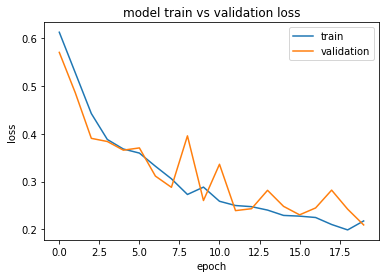

In [88]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

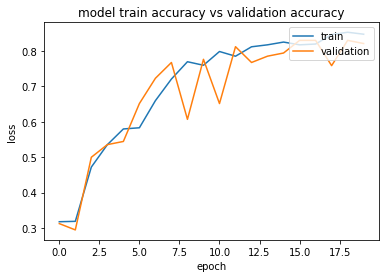

In [89]:
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('model train accuracy vs validation accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [90]:
pred2 = model.predict_generator(generator=test_generator_df).argmax(-1)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [92]:
print(accuracy_score(pred2,y_test_arr))

0.8495575221238938


In [93]:
print(classification_report(y_test_arr, pred2))

              precision    recall  f1-score   support

           0       0.85      0.77      0.81        30
           1       0.78      0.86      0.82        21
           2       0.77      0.88      0.82        26
           3       0.97      0.89      0.93        36

    accuracy                           0.85       113
   macro avg       0.84      0.85      0.84       113
weighted avg       0.86      0.85      0.85       113



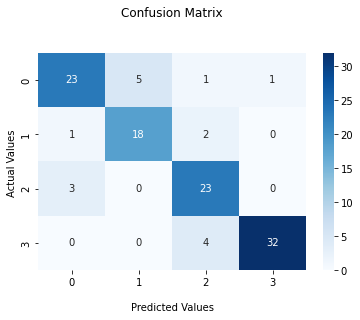

In [94]:
ax = sns.heatmap(confusion_matrix(y_test_arr, pred2), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
plt.show()

In [52]:
import keras
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, add, GlobalAveragePooling2D
from keras.models import Model

def resnet_block(inputs, filters, kernel_size, strides, use_shortcut=False):
  x = Conv2D(filters, kernel_size, strides=strides, padding='same')(inputs)
  x = Activation('relu')(x)
  x = Conv2D(filters, kernel_size, strides=1, padding='same')(x)
  x = Activation('relu')(x)
  if use_shortcut:
    shortcut = Conv2D(filters, 1, strides=strides)(inputs)
    x = add([x, shortcut])
  return x

def build_resnet(input_shape, num_classes):
  inputs = Input(shape=input_shape)
  x = Conv2D(64, 7, strides=2, padding='same')(inputs)
  x = MaxPooling2D(3, strides=2, padding='same')(x)
  for i in range(3):
    for j in range(3):
      strides = 1
      if i > 0:
        strides = 2
      x = resnet_block(x, 64, 3, strides, use_shortcut=(j == 0) and (i > 0))
  x = GlobalAveragePooling2D()(x)
  x = Dense(num_classes, activation='softmax')(x)
  model = Model(inputs, x)
  return model

# Build and compile the model
input_shape = (64, 64, 3)
num_classes = 4
model = build_resnet(input_shape, num_classes)
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['acc'])

# Load the training data and train the model
history2 = model.fit(train_generator_df, epochs=20,
                   validation_data=valid_generator_df)

Epoch 1/20
57/57 [==============================] - 4s 61ms/step - loss: 1.3475 - acc: 0.3444 - val_loss: 1.2708 - val_acc: 0.4107
Epoch 2/20
57/57 [==============================] - 4s 63ms/step - loss: 0.9824 - acc: 0.5511 - val_loss: 0.9113 - val_acc: 0.5982
Epoch 3/20
57/57 [==============================] - 3s 47ms/step - loss: 0.8384 - acc: 0.5889 - val_loss: 0.9816 - val_acc: 0.6339
Epoch 4/20
57/57 [==============================] - 3s 44ms/step - loss: 0.8115 - acc: 0.6622 - val_loss: 0.8606 - val_acc: 0.6161
Epoch 5/20
57/57 [==============================] - 3s 47ms/step - loss: 0.6865 - acc: 0.7389 - val_loss: 0.6719 - val_acc: 0.7679
Epoch 6/20
57/57 [==============================] - 3s 44ms/step - loss: 0.6001 - acc: 0.8089 - val_loss: 0.6990 - val_acc: 0.6875
Epoch 7/20
57/57 [==============================] - 2s 42ms/step - loss: 0.5941 - acc: 0.7889 - val_loss: 0.5042 - val_acc: 0.7946
Epoch 8/20
57/57 [==============================] - 2s 43ms/step - loss: 0.5987 - a

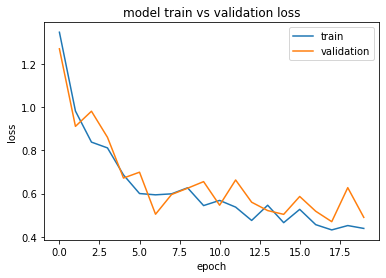

In [53]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

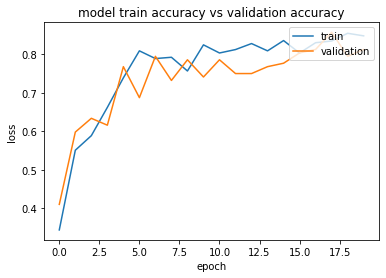

In [54]:
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('model train accuracy vs validation accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


0.831858407079646
              precision    recall  f1-score   support

           0       0.87      0.67      0.75        30
           1       0.67      0.86      0.75        21
           2       0.79      0.88      0.84        26
           3       0.97      0.92      0.94        36

    accuracy                           0.83       113
   macro avg       0.82      0.83      0.82       113
weighted avg       0.85      0.83      0.83       113



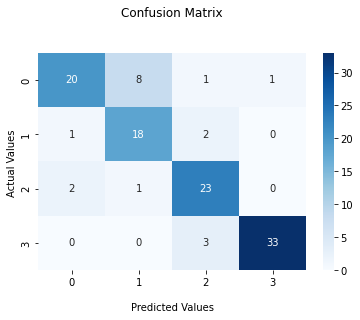

In [55]:
pred2 = model.predict_generator(generator=test_generator_df).argmax(-1)
print(accuracy_score(pred2,y_test_arr))
print(classification_report(y_test_arr, pred2))
ax = sns.heatmap(confusion_matrix(y_test_arr, pred2), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
plt.show()

LeNet

In [46]:
import keras
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Model

def build_lenet(input_shape, num_classes):
  inputs = Input(shape=input_shape)
  x = Conv2D(6, 5, activation='relu', padding='same')(inputs)
  x = MaxPooling2D(2, 2)(x)
  x = Conv2D(16, 5, activation='relu')(x)
  x = MaxPooling2D(2, 2)(x)
  x = Flatten()(x)
  x = Dense(120, activation='relu')(x)
  x = Dense(84, activation='relu')(x)
  x = Dense(num_classes, activation='softmax')(x)
  model = Model(inputs, x)
  return model

# Build and compile the model
input_shape = (64, 64, 3)
num_classes = 4
model3 = build_lenet(input_shape, num_classes)
# model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model3.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['acc'])

# Load the training data and train the model
history3 = model3.fit(train_generator_df, epochs=20,
                   validation_data=valid_generator_df)


Epoch 1/20
57/57 [==============================] - 3s 43ms/step - loss: 3.2180 - acc: 0.5867 - val_loss: 1.8627 - val_acc: 0.6518
Epoch 2/20
57/57 [==============================] - 3s 52ms/step - loss: 1.4675 - acc: 0.6544 - val_loss: 1.0567 - val_acc: 0.7054
Epoch 3/20
57/57 [==============================] - 3s 49ms/step - loss: 0.8757 - acc: 0.7756 - val_loss: 0.9857 - val_acc: 0.7143
Epoch 4/20
57/57 [==============================] - 2s 39ms/step - loss: 0.8338 - acc: 0.7633 - val_loss: 1.0022 - val_acc: 0.7411
Epoch 5/20
57/57 [==============================] - 2s 40ms/step - loss: 0.7193 - acc: 0.7678 - val_loss: 0.9485 - val_acc: 0.7589
Epoch 6/20
57/57 [==============================] - 2s 39ms/step - loss: 0.6662 - acc: 0.8133 - val_loss: 0.5741 - val_acc: 0.8304
Epoch 7/20
57/57 [==============================] - 2s 39ms/step - loss: 0.5870 - acc: 0.8267 - val_loss: 0.7067 - val_acc: 0.7500
Epoch 8/20
57/57 [==============================] - 3s 49ms/step - loss: 0.6076 - a

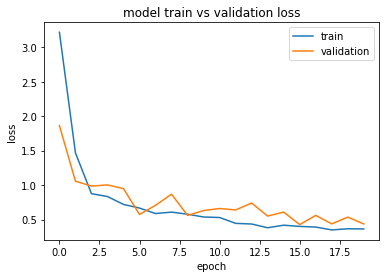

In [47]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

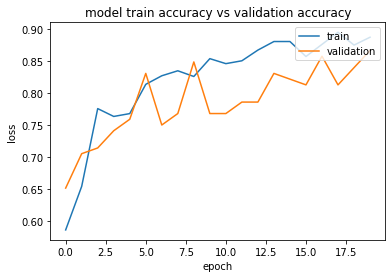

In [48]:
plt.plot(history3.history['acc'])
plt.plot(history3.history['val_acc'])
plt.title('model train accuracy vs validation accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [49]:
pred_leNet = model3.predict_generator(generator=test_generator_df).argmax(-1)
print(accuracy_score(y_test_arr,pred_leNet))

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


0.8407079646017699


In [50]:
print(classification_report(y_test_arr, pred_leNet))

              precision    recall  f1-score   support

           0       0.91      0.67      0.77        30
           1       0.69      0.95      0.80        21
           2       0.79      0.88      0.84        26
           3       0.97      0.89      0.93        36

    accuracy                           0.84       113
   macro avg       0.84      0.85      0.83       113
weighted avg       0.86      0.84      0.84       113



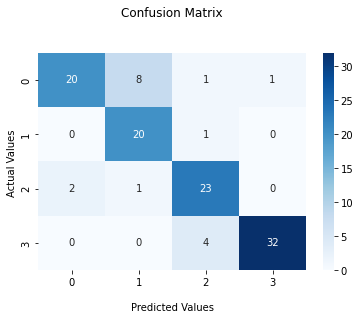

In [51]:
ax = sns.heatmap(confusion_matrix(y_test_arr, pred_leNet), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
plt.show()

In [20]:
import tensorflow as tf

def resnet_block(input_tensor, filters, strides):
  x = tf.keras.layers.Conv2D(filters, 3, strides=strides, padding='same')(input_tensor)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.Conv2D(filters, 3, strides=1, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  return x

def resnet_layer(input_tensor, filters, strides):
  x = resnet_block(input_tensor, filters, strides)
  if strides != 1:
    input_tensor = tf.keras.layers.Conv2D(filters, 1, strides=strides)(input_tensor)
  x = tf.keras.layers.add([x, input_tensor])
  x = tf.keras.layers.Activation('relu')(x)
  return x

inputs = tf.keras.Input(shape=(64, 64, 3))
x = tf.keras.layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPooling2D(3, strides=2, padding='same')(x)

filters = 64
for i in range(5):
  strides = 1 if i == 0 else 2
  x = resnet_layer(x, filters, strides)
  filters *= 2

x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
history3 = model.fit(train_generator_df, epochs=20,
                   validation_data=valid_generator_df)

Epoch 1/20
57/57 [==============================] - 5s 53ms/step - loss: 1.2643 - accuracy: 0.4689 - val_loss: 1.3400 - val_accuracy: 0.3304
Epoch 2/20
57/57 [==============================] - 3s 48ms/step - loss: 0.7950 - accuracy: 0.6789 - val_loss: 1.2862 - val_accuracy: 0.3482
Epoch 3/20
57/57 [==============================] - 3s 54ms/step - loss: 0.7375 - accuracy: 0.7000 - val_loss: 1.1205 - val_accuracy: 0.5089
Epoch 4/20
57/57 [==============================] - 3s 55ms/step - loss: 0.6436 - accuracy: 0.7522 - val_loss: 0.9157 - val_accuracy: 0.5982
Epoch 5/20
57/57 [==============================] - 3s 46ms/step - loss: 0.6681 - accuracy: 0.7556 - val_loss: 0.8372 - val_accuracy: 0.6429
Epoch 6/20
57/57 [==============================] - 3s 46ms/step - loss: 0.5975 - accuracy: 0.7644 - val_loss: 0.7074 - val_accuracy: 0.6607
Epoch 7/20
57/57 [==============================] - 3s 54ms/step - loss: 0.5808 - accuracy: 0.7633 - val_loss: 0.7066 - val_accuracy: 0.6964
Epoch 8/20
57

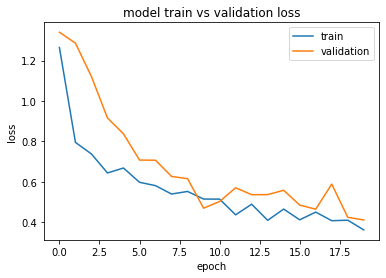

In [22]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

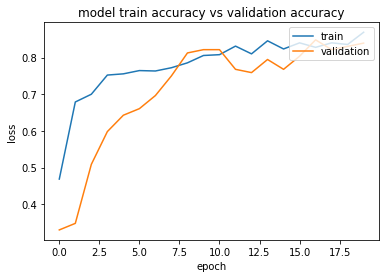

In [23]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model train accuracy vs validation accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [27]:
pred_resnet20 = model.predict_generator(generator=test_generator_df).argmax(-1)
print(accuracy_score(y_test_arr,pred_resnet20))

0.8761061946902655


              precision    recall  f1-score   support

           0       0.93      0.83      0.88        30
           1       0.79      0.90      0.84        21
           2       0.79      0.85      0.81        26
           3       0.97      0.92      0.94        36

    accuracy                           0.88       113
   macro avg       0.87      0.88      0.87       113
weighted avg       0.88      0.88      0.88       113



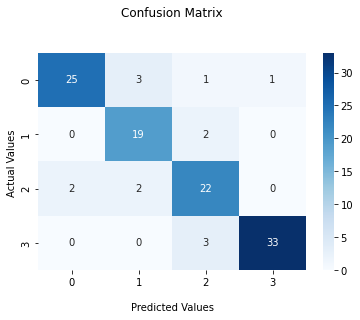

In [28]:
print(classification_report(y_test_arr, pred_resnet20))
ax = sns.heatmap(confusion_matrix(y_test_arr, pred_resnet20), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
plt.show()

In [ ]:
import tensorflow as tf

model = tf.keras.applications.ResNet50(weights='imagenet')

In [33]:
base_model = tf.keras.applications.ResNet50(
        input_shape=(64, 64, 3),
        include_top=False,
        weights="imagenet",
)

base_model.trainable = True
model2 = tf.keras.Sequential([
    tf.keras.Input(shape=(64, 64, 3)),
    data_augmentation,
    layers.Rescaling(scale=1.0/255), # rescale the pixel values to the [0, 1] range
    base_model,
    # add a new FC classifier on top of the base model
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(4, activation='softmax'),
])
learning_rate = 1e-5
model2.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=['acc']
             )

epochs = 20
history_vgg_sparse = model2.fit(train_generator_df, epochs=epochs,
                   validation_data=valid_generator_df)

Epoch 1/20
57/57 [==============================] - 10s 79ms/step - loss: 1.5766 - acc: 0.3922 - val_loss: 2.3739 - val_acc: 0.1964
Epoch 2/20
57/57 [==============================] - 4s 68ms/step - loss: 0.9690 - acc: 0.6300 - val_loss: 8.2463 - val_acc: 0.1964
Epoch 3/20
57/57 [==============================] - 3s 57ms/step - loss: 0.7362 - acc: 0.7233 - val_loss: 17.7216 - val_acc: 0.1964
Epoch 4/20
57/57 [==============================] - 4s 65ms/step - loss: 0.6040 - acc: 0.7800 - val_loss: 22.3913 - val_acc: 0.3304
Epoch 5/20
57/57 [==============================] - 3s 58ms/step - loss: 0.5401 - acc: 0.8000 - val_loss: 67.4056 - val_acc: 0.3125
Epoch 6/20
57/57 [==============================] - 3s 57ms/step - loss: 0.4547 - acc: 0.8500 - val_loss: 138.9934 - val_acc: 0.3125
Epoch 7/20
57/57 [==============================] - 3s 57ms/step - loss: 0.4271 - acc: 0.8567 - val_loss: 141.0569 - val_acc: 0.3214
Epoch 8/20
57/57 [==============================] - 4s 62ms/step - loss: 0.

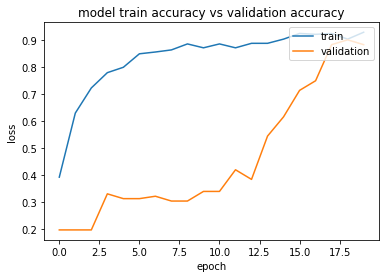

In [37]:
plt.plot(history_vgg_sparse.history['acc'])
plt.plot(history_vgg_sparse.history['val_acc'])
plt.title('model train accuracy vs validation accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

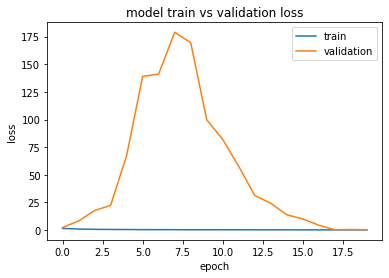

In [38]:
plt.plot(history_vgg_sparse.history['loss'])
plt.plot(history_vgg_sparse.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [39]:
pred_resnet20 = model2.predict_generator(generator=test_generator_df).argmax(-1)
print(accuracy_score(y_test_arr,pred_resnet20))

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


0.9026548672566371


              precision    recall  f1-score   support

           0       0.96      0.80      0.87        30
           1       0.78      1.00      0.88        21
           2       0.86      0.92      0.89        26
           3       1.00      0.92      0.96        36

    accuracy                           0.90       113
   macro avg       0.90      0.91      0.90       113
weighted avg       0.92      0.90      0.90       113



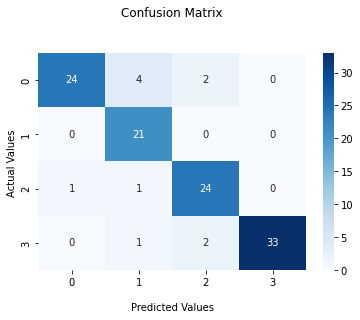

In [40]:
print(classification_report(y_test_arr, pred_resnet20))
ax = sns.heatmap(confusion_matrix(y_test_arr, pred_resnet20), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
plt.show()

In [41]:
res_acc = [92.920, 87.610, 90.265, 84.070]
res_acc_name = ['VGG19', 'ResNet-18', 'ResNet-50', 'LeNet']

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

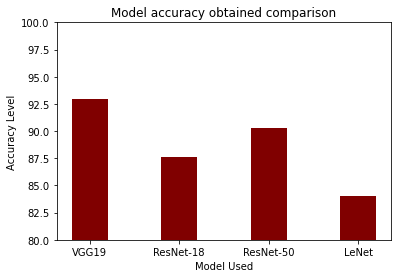

In [50]:
plt.bar(res_acc_name, res_acc, color ='maroon',
        width = 0.4)
 
plt.ylabel("Accuracy Level")
plt.xlabel("Model Used")
plt.title("Model accuracy obtained comparison")
plt.ylim([80, 100])
plt.show()